# Esquema del modelo definitivo

## I. Librerias y funciones

In [2]:
#Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from lazypredict.Supervised import LazyRegressor
import pickle
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Función para convertir los datos en secuencias de tiempo
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

## II. Procesado del DF

In [4]:
#Covid transofromar en niveles de restricciones
df = pd.read_csv(r'C:/Users/minip/OneDrive - Universidad de Málaga/Documentos/4Geek/Proyecto final/AMH-proyecto-final/data/DF_modelos/df_residencial_total.csv')
df = df.drop(columns=['Sector_Economic','año','COVID','festivos','prec','velmedia','Rentanetamediaporpersona','Rentanetamediaporhogar','bono_social','poblacion','lectivos']) 
df

,consumo,fecha,findesemana,tmed,PIB
0,6713701,2019-01-01,0,8.59,62490
1,7354663,2019-01-02,0,6.62,62490
2,7619413,2019-01-03,0,5.60,62490
3,7815514,2019-01-04,0,5.00,63436
4,7527041,2019-01-05,1,6.17,62490
...,...,...,...,...,...
2003,5404940,2024-06-26,0,22.62,77268
2004,5326951,2024-06-27,0,23.78,77268
2005,5490645,2024-06-28,0,24.45,77268
2006,5137699,2024-06-29,1,20.94,77268


In [5]:
#Eliminar consumos anomalos
index_primera_menor_1000 = df[df['consumo'] < 200000].index.min()

# Eliminar todas las filas desde ese índice en adelante
if index_primera_menor_1000 is not None:
    df = df.loc[:index_primera_menor_1000-1]

df

,consumo,fecha,findesemana,tmed,PIB
0,6713701,2019-01-01,0,8.59,62490
1,7354663,2019-01-02,0,6.62,62490
2,7619413,2019-01-03,0,5.60,62490
3,7815514,2019-01-04,0,5.00,63436
4,7527041,2019-01-05,1,6.17,62490
...,...,...,...,...,...
1943,4803374,2024-04-27,1,14.11,77268
1944,5117827,2024-04-28,1,12.46,77268
1945,5699315,2024-04-29,0,11.62,77268
1946,5269315,2024-04-30,0,13.54,77268


In [6]:
#Retardo del consumo
df['t-1'] = df['consumo'].shift(1)

In [7]:
#Eliminar filas con valores nulos
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

,consumo,fecha,findesemana,tmed,PIB,t-1
0,7354663,2019-01-02,0,6.62,62490,6713701.00
1,7619413,2019-01-03,0,5.60,62490,7354663.00
2,7815514,2019-01-04,0,5.00,63436,7619413.00
3,7527041,2019-01-05,1,6.17,62490,7815514.00
4,7308657,2019-01-06,1,9.13,63436,7527041.00
...,...,...,...,...,...,...
1942,4803374,2024-04-27,1,14.11,77268,5167220.00
1943,5117827,2024-04-28,1,12.46,77268,4803374.00
1944,5699315,2024-04-29,0,11.62,77268,5117827.00
1945,5269315,2024-04-30,0,13.54,77268,5699315.00


In [8]:
df.dtypes

consumo          int64
fecha           object
findesemana      int64
tmed           float64
PIB              int64
t-1            float64
dtype: object

In [9]:
df.nunique()

consumo        1917
fecha          1947
findesemana       2
tmed           1847
PIB              22
t-1            1917
dtype: int64

In [10]:
df.shape

(1947, 6)

In [11]:
# Asegúrate de que la columna de fecha está en formato datetime
# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias

In [12]:
df

,consumo,fecha,findesemana,tmed,PIB,t-1
0,7354663,1546387200,0,6.62,62490,6713701.00
1,7619413,1546473600,0,5.60,62490,7354663.00
2,7815514,1546560000,0,5.00,63436,7619413.00
3,7527041,1546646400,1,6.17,62490,7815514.00
4,7308657,1546732800,1,9.13,63436,7527041.00
...,...,...,...,...,...,...
1942,4803374,1714176000,1,14.11,77268,5167220.00
1943,5117827,1714262400,1,12.46,77268,4803374.00
1944,5699315,1714348800,0,11.62,77268,5117827.00
1945,5269315,1714435200,0,13.54,77268,5699315.00


In [24]:
df.to_csv(r"C:/Users/minip/OneDrive - Universidad de Málaga/Documentos/4Geek/Proyecto final/AMH-proyecto-final/data/DF_modelos/df_residencial_modelo.csv", index = False)
#df.to_csv("../data/DF_modelos/df_residencial_modelo.csv", index = False)

## III. Analisis de variables potenciales

In [63]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo'])  
y = df['consumo']  

test_size_percentage = 0.09
split_index = int(len(X) * (1 - test_size_percentage))

# Dividir en conjunto de entrenamiento (primera parte) y prueba (última parte)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [64]:
#Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
# Modelo para seleccion de caracteristicas importantes
# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (RMSE) como métrica de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Obtener la importancia de las características
importancia = model_xgb.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia*100})
feature_importance = feature_importance.sort_values(by='Importancia', ascending=False)
# Mostrar las variables ordenadas por importancia
print(feature_importance)

RMSE: 1153578.852653748
      Variable  Importancia
4          t-1    86.215355
2         tmed     5.467726
1  findesemana     4.123895
3          PIB     2.208431
0        fecha     1.984598


C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [67]:
# convertir de array a pandas para el VIF
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_train_selected = df_X_train_scaled[['findesemana', 't-1', 'tmed', 'fecha','PIB']]
df_X_train_selected

,findesemana,t-1,tmed,fecha,PIB
0,-0.632456,0.658950,-1.391208,-1.731073,-0.324258
1,-0.632456,1.325940,-1.545792,-1.729117,-0.324258
2,-0.632456,1.601442,-1.637348,-1.727161,-0.166267
3,1.581139,1.805506,-1.458879,-1.725205,-0.324258
4,1.581139,1.505318,-1.007733,-1.723249,-0.166267
...,...,...,...,...,...
1766,-0.632456,-0.868453,-0.601038,1.723249,1.695217
1767,1.581139,-0.821020,-0.363522,1.725205,1.695217
1768,1.581139,-0.944644,-0.266659,1.727161,1.695217
1769,-0.632456,-0.876637,-0.523414,1.729117,1.695217


In [68]:
#Test VIF
vif = pd.Series([variance_inflation_factor(df_X_train_selected.corr().values, i) for i in range(df_X_train_selected.corr().shape[1])], index=df_X_train_selected.columns)
vif

findesemana     1.030767
t-1             2.189669
tmed            1.805922
fecha          16.653785
PIB            15.266375
dtype: float64

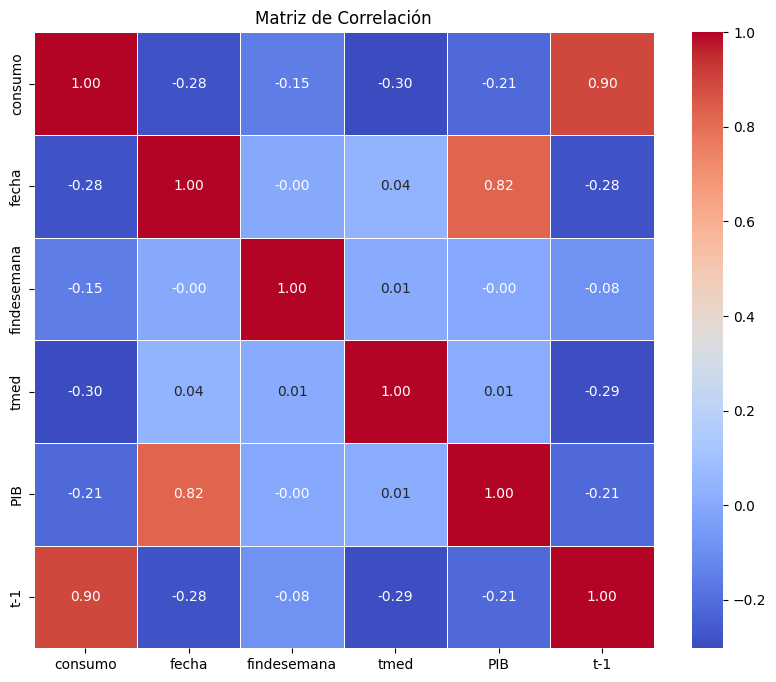

In [67]:
# Correlacion individual
correlation_matrix = df.corr()
# Mostrar la matriz de correlación
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

## IV. Modelo LSTM

### IV.I. Preparar datos

In [13]:
#Ordenar los datos cronologicamnte
df = df.sort_values(by='fecha')

In [14]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo','fecha'])  
y = df['consumo']

In [15]:
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [16]:
# Dividir en conjunto de entrenamiento y prueba (manteniendo el orden temporal)
train_size = int(len(X) * 0.9)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [72]:
X_train

array([[0.        , 0.17305586, 0.47159152, 0.47750606],
       [0.        , 0.13898399, 0.47159152, 0.52766622],
       [0.        , 0.11880408, 0.5054171 , 0.54838492],
       ...,
       [0.        , 0.57753139, 0.90395824, 0.35787951],
       [0.        , 0.65459524, 0.90395824, 0.35876022],
       [0.        , 0.57799097, 0.90395824, 0.36837542]])

In [73]:
X_test

array([[0.00000000e+00, 5.09680107e-01, 9.03958236e-01, 3.61944918e-01],
       [1.00000000e+00, 4.32908722e-01, 9.03958236e-01, 3.47572046e-01],
       [1.00000000e+00, 4.13459971e-01, 9.03958236e-01, 3.26982154e-01],
       [0.00000000e+00, 5.86743955e-01, 9.03958236e-01, 3.31753912e-01],
       [0.00000000e+00, 4.88184119e-01, 9.03958236e-01, 3.53715112e-01],
       [0.00000000e+00, 5.13774581e-01, 9.03958236e-01, 3.48779639e-01],
       [0.00000000e+00, 5.92739434e-01, 9.03958236e-01, 3.46990826e-01],
       [0.00000000e+00, 4.94910755e-01, 9.03958236e-01, 3.49165684e-01],
       [1.00000000e+00, 4.94033368e-01, 9.03958236e-01, 3.42770784e-01],
       [1.00000000e+00, 5.02953472e-01, 9.03958236e-01, 3.27924141e-01],
       [0.00000000e+00, 4.69466525e-01, 9.03958236e-01, 3.32245370e-01],
       [0.00000000e+00, 3.71365324e-01, 9.03958236e-01, 3.53806830e-01],
       [0.00000000e+00, 4.05124792e-01, 9.03958236e-01, 3.36672873e-01],
       [0.00000000e+00, 4.21063994e-01, 9.03958236e

In [17]:
# Crear secuencias de tiempo para LSTM
time_steps = 1  # Esto significa que la predicción se basará en los últimos 10 días
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)
print(f"Forma de X_train_seq: {X_train_seq.shape}")  # Debe ser (samples, time_steps, features)

Forma de X_train_seq: (1751, 1, 4)


In [75]:
X_test_seq[0]

array([[0.        , 0.50968011, 0.90395824, 0.36194492]])

In [76]:
X_test[:4]

array([[0.        , 0.50968011, 0.90395824, 0.36194492],
       [1.        , 0.43290872, 0.90395824, 0.34757205],
       [1.        , 0.41345997, 0.90395824, 0.32698215],
       [0.        , 0.58674395, 0.90395824, 0.33175391]])

In [77]:
y_test_seq[0]

array([0.32698215])

In [78]:
y_test[:4]

array([[0.34757205],
       [0.32698215],
       [0.33175391],
       [0.35371511]])

### IV.II. Definir modelo LSTM

Mejores hiperparámetros: {'units_lstm1': 64, 'units_lstm2': 64, 'dropout_rate': 0.2, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 100}
Mejor MSE en validación: 0.0016992252343753177

In [18]:
# Definir el modelo LSTM
model = Sequential()

In [19]:
# Primera capa LSTM con 50 unidades y dropout para regularización
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
# Segunda capa LSTM
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
# Capa de salida para la predicción continua de la demanda de electricidad
model.add(Dense(1))

In [20]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

### IV.III Entrenamiento del Modelo

In [26]:
# Entrenamiento conm 100 epocas
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1149 - val_loss: 0.0095
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

### IV.IV. Evaluacion del Modelo

In [27]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Loss: {loss}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026    
Loss: 0.004660025704652071


In [28]:
#Comprobar la prediccion
# Predecir los valores de prueba
y_pred_scaled = model.predict(X_test_seq)
# Desescalar las predicciones y los valores reales para comparar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)
# Comparar las primeras predicciones con los valores reales
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_true[:5].flatten()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Predicciones: [5188238.  5236503.5 5093401.  5015520.  5114548.5]
Valores reales: [4790260. 4851235. 5131862. 5068795. 5045937.]


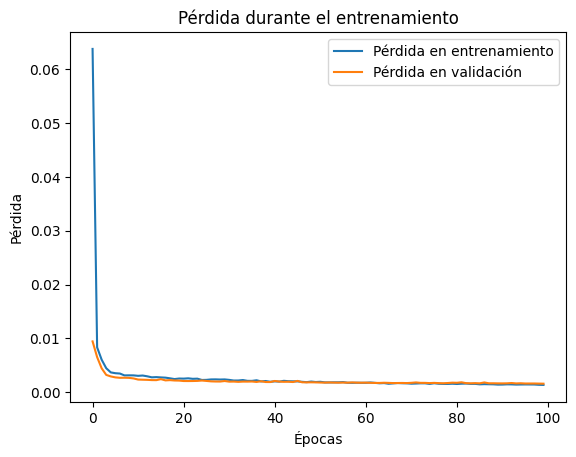

In [29]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [30]:
# Calcular el MAPE
mape = mean_absolute_percentage_error(y_test_true, y_pred)
print(f'MAPE: {mape:.4f}')

MAPE: 0.2333


In [31]:
# Calcular el r**2
y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
print(f'R²: {r2:.4f}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R²: 0.7398


In [32]:
# Calcular el MSE
mse = model.evaluate(X_val, y_val)
print(f"Mean Squared Error en el conjunto de validación: {mse}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022     
Mean Squared Error en el conjunto de validación: 0.0016092384466901422


## IV. V. Optimizacion

In [23]:
# Definir el modelo LSTM directamente
def create_model(units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units_lstm1, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units_lstm2, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [24]:
# Generar combinaciones de hiperparámetros manualmente
param_grid = {
    'units_lstm1': [16, 32, 64],
    'units_lstm2': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [25]:
# División en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X_train_seq, y_train_seq, test_size=0.2, random_state=42)

In [66]:
# Loop manual para probar diferentes combinaciones de hiperparámetros
best_model = None
best_mse = np.inf
best_params = None
for units_lstm1 in param_grid['units_lstm1']:
    for units_lstm2 in param_grid['units_lstm2']:
        for dropout_rate in param_grid['dropout_rate']:
            for optimizer in param_grid['optimizer']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        print(f"Entrenando modelo con units_lstm1={units_lstm1}, units_lstm2={units_lstm2}, dropout_rate={dropout_rate}, optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}")
                        # Crear el modelo
                        model = create_model(units_lstm1, units_lstm2, dropout_rate, optimizer)
                        # Entrenar el modelo
                        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                        # Evaluar el modelo en el conjunto de validación
                        y_pred = model.predict(X_val)
                        mse = mean_squared_error(y_val, y_pred)
                        # Si el modelo actual es mejor, guardar como mejor modelo
                        if mse < best_mse:
                            best_mse = mse
                            best_model = model
                            best_params = {
                                'units_lstm1': units_lstm1,
                                'units_lstm2': units_lstm2,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor MSE en validación: {best_mse}")

Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=adam, batch_size=32, epochs=50


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=adam, batch_size=32, epochs=100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=adam, batch_size=64, epochs=50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=adam, batch_size=64, epochs=100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=rmsprop, batch_size=32, epochs=50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=rmsprop, batch_size=32, epochs=100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Entrenando modelo con units_lstm1=16, units_lstm2=32, dropout_rate=0.2, optimizer=rmsprop, batch_size=64, epochs=50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Entrenando modelo con units_ls

## V. Guardar modelo y la escala no vaya a ser que se nos borre 

In [33]:
#Extraccion del modelo en la carpeta modelos
model.save('../models/modelo_residencial_Def.h5')

In [51]:
# Guardamos el objeto escalador x con pickle
with open('scaler_X_res.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

In [52]:
#Guardamos el objeto escalador y con pickle
with open('scaler_y_res.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)